
=== Training Scores ===
Train Accuracy: 0.8359
Train ROC AUC: 0.9169

=== Validation Scores ===
Validation Accuracy: 0.9000
Validation ROC AUC: 0.9207

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       123
           1       0.76      0.84      0.79        37

    accuracy                           0.90       160
   macro avg       0.85      0.88      0.86       160
weighted avg       0.90      0.90      0.90       160

Best Threshold: 0.5867
F1 Score: 0.7949


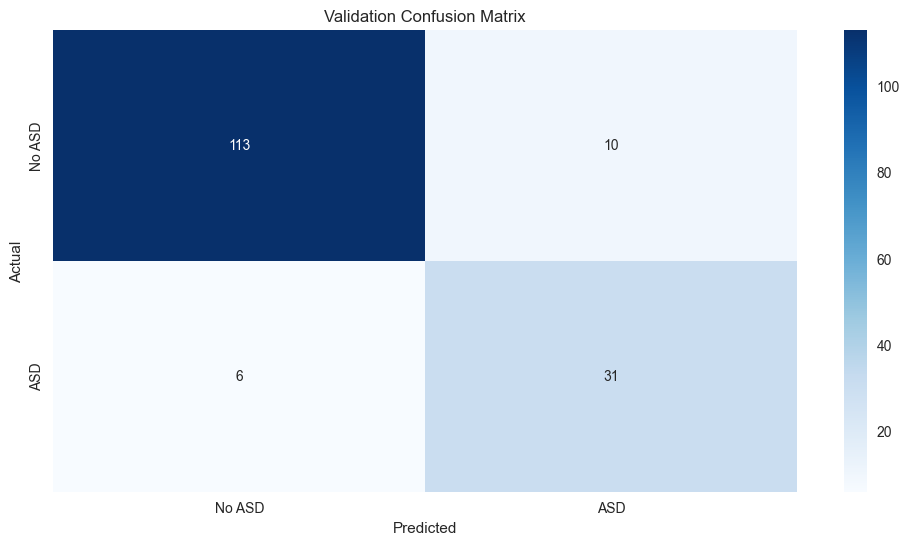

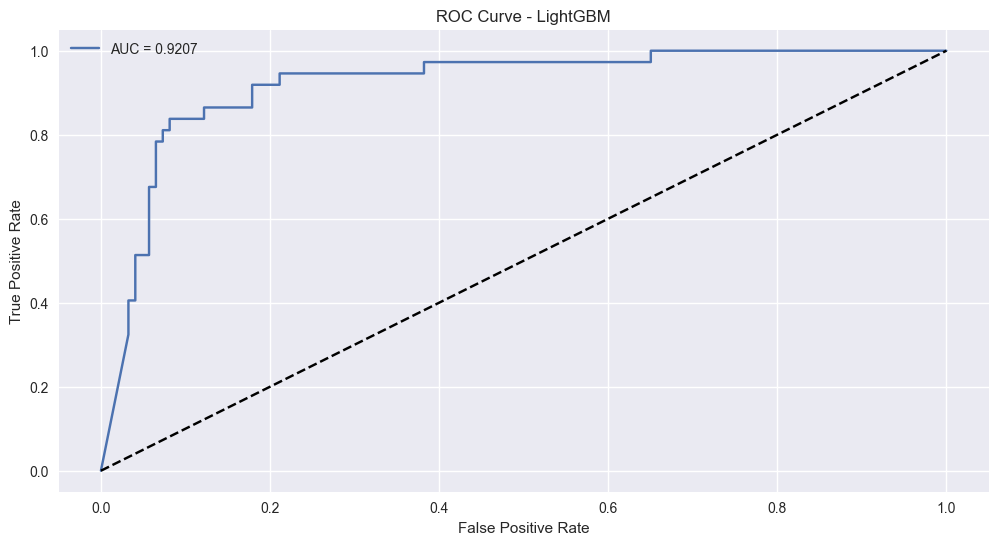


=== Cross-Validation Scores ===
CV Accuracy: 0.8463 ± 0.0161
CV ROC AUC:  0.9059 ± 0.0077

Test predictions saved to 'final_lgbm_submission.csv'
Positive Cases in Test Set: 53 out of 200


In [27]:
# ===============================
#        IMPORTS
# ===============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTEENN
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score,
                             confusion_matrix, classification_report,
                             precision_recall_curve, roc_curve)
import warnings
warnings.filterwarnings("ignore")

# ===============================
#        LOAD DATA
# ===============================
train_data = pd.read_csv("Autism-prediction/train (1).csv")
test_data = pd.read_csv("Autism-prediction/test.csv")

# ===============================
#     FEATURE ENGINEERING
# ===============================
aq_cols = [f"A{i}_Score" for i in range(1, 11)]
for df in [train_data, test_data]:
    df['AQ_Total'] = df[aq_cols].sum(axis=1)
    df['AQ_Mean'] = df[aq_cols].mean(axis=1)
    df['Result_Log'] = np.log1p(df['result'])
    df['AQ_Result_Ratio'] = df['AQ_Total'] / (df['result'] + 0.1)
    df['Age_Sq'] = df['age'] ** 2
    df['Family_Autism'] = (df['austim'] == 'yes').astype(int)
    df['Had_Jaundice'] = (df['jaundice'] == 'yes').astype(int)

# ===============================
#         ENCODING SETUP
# ===============================
cat_cols = ['relation', 'ethnicity', 'contry_of_res', 'gender']
for col in cat_cols:
    for df in [train_data, test_data]:
        df[col] = df[col].fillna("Unknown").replace("?", "Unknown").astype(str)

# Label encode to convert to numeric (for imputation to work properly)
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    combined = pd.concat([train_data[col], test_data[col]])
    le.fit(combined)
    train_data[col] = le.transform(train_data[col])
    test_data[col] = le.transform(test_data[col])
    le_dict[col] = le

# ===============================
#         FEATURE SETUP
# ===============================
excluded_cols = ['ID', 'Class/ASD', 'jaundice', 'austim', 'used_app_before', 'age_desc']
features = [col for col in train_data.columns if col not in excluded_cols]
X = train_data[features]
y = train_data['Class/ASD']
X_final_test = test_data[features]

# ===============================
#     TRAIN-VALIDATION SPLIT
# ===============================
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# ===============================
#     PREPROCESSING PIPELINE
# ===============================
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features)
])

# ===============================
#      OPTIMIZED LGBM MODEL
# ===============================
lgbm_params = {
    'n_estimators': 176,
    'max_depth': 6,
    'learning_rate': 0.0015909428004919131,
    'subsample': 0.9543050806871795,
    'colsample_bytree': 0.5003029787156504,
    'reg_alpha': 1.1503524466697064,
    'reg_lambda': 0.69585017112964,
    'random_state': 42,
    'class_weight': 'balanced',
    'n_jobs': -1
}
model = ImbPipeline([
    ('preprocess', preprocessor),
    ('smoteenn', SMOTEENN(random_state=42)),
    ('clf', LGBMClassifier(**lgbm_params))
])

# ===============================
#        TRAINING & EVAL
# ===============================
model.fit(X_train, y_train)

# TRAINING METRICS
train_probs = model.predict_proba(X_train)[:, 1]
train_preds = model.predict(X_train)
print("\n=== Training Scores ===")
print(f"Train Accuracy: {accuracy_score(y_train, train_preds):.4f}")
print(f"Train ROC AUC: {roc_auc_score(y_train, train_probs):.4f}")

# VALIDATION METRICS
val_probs = model.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, val_probs)
f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
best_thresh = thresholds[np.argmax(f1_scores)]
val_preds = (val_probs >= best_thresh).astype(int)

print("\n=== Validation Scores ===")
print(f"Validation Accuracy: {accuracy_score(y_val, val_preds):.4f}")
print(f"Validation ROC AUC: {roc_auc_score(y_val, val_probs):.4f}")
print(f"\nClassification Report:\n{classification_report(y_val, val_preds)}")
print(f"Best Threshold: {best_thresh:.4f}")
print(f"F1 Score: {f1_score(y_val, val_preds):.4f}")

# ===============================
#         CONFUSION MATRIX
# ===============================
cm = confusion_matrix(y_val, val_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No ASD", "ASD"], yticklabels=["No ASD", "ASD"])
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ===============================
#            ROC CURVE
# ===============================
fpr, tpr, _ = roc_curve(y_val, val_probs)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_val, val_probs):.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LightGBM")
plt.legend()
plt.grid(True)
plt.show()

# ===============================
#     CROSS-VALIDATION METRICS
# ===============================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_acc = cross_val_score(model, X, y, scoring='accuracy', cv=cv)
cv_auc = cross_val_score(model, X, y, scoring='roc_auc', cv=cv)

print("\n=== Cross-Validation Scores ===")
print(f"CV Accuracy: {cv_acc.mean():.4f} ± {cv_acc.std():.4f}")
print(f"CV ROC AUC:  {cv_auc.mean():.4f} ± {cv_auc.std():.4f}")

# ===============================
#     TEST SET PREDICTIONS
# ===============================
test_probs = model.predict_proba(X_final_test)[:, 1]
test_preds = (test_probs >= best_thresh).astype(int)

submission = pd.DataFrame({
    'ID': test_data['ID'],
    'Class/ASD_Prob': test_probs,
    'Class/ASD': test_preds
})
submission.to_csv('final_lgbm_submission.csv', index=False)
print("\nTest predictions saved to 'final_lgbm_submission.csv'")
print(f"Positive Cases in Test Set: {test_preds.sum()} out of {len(test_preds)}")
